## Logistic on Raw EEG Signals - Insights on Bridging the Temporal-Spatial Gap

This notebook performs **logistic regression analysis** on raw EEG data captured during a motor imagery task. The goal is to examine the temporal structure of the EEG signals, specifically focusing on the period **immediately following the cue onset**. By analyzing the data with logistic regression, we aim to uncover key **temporal patterns** that differentiate between motor imagery of the left and right hand.

Logistic regression is a **linear model** that allows us to inspect the importance of various timepoints through **coefficient significance heatmaps**. These maps reveal the most critical moments where the brain's activity is most distinguishable between different motor imagery conditions. In particular, we observe the strongest coefficients between **0.1 and 0.3 seconds** after the cue, a time window that corresponds to the initiation and performance of motor imagery.

The insights drawn from this analysis, including the identification of **key timepoints** and **electrode activations**, will inform the development of a more sophisticated classification method. Specifically, we aim to use these logistic regression findings to propose a refined approach for **CNN-based classification** by stacking 2D topological maps at the most significant timepoints. This will bridge the gap between the temporal insights revealed by logistic regression and the spatial capabilities of CNNs, ultimately improving classification performance for real-time **Brain-Computer Interface (BCI)** systems.

In this notebook, we will:
- Run logistic regression on raw EEG data.
- Visualize the **coefficient significance heatmap** to identify important time windows and electrodes.
- Interpret the results in the context of motor imagery differentiation and suggest improvements in future CNN-based models.


In [1]:
%%capture
!pip install mne
! pip install tensorflow

In [2]:
%%capture
import gc
import mne
import os
import matplotlib.pyplot as plt
import numpy as np
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP


from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Set the random seed for NumPy
np.random.seed(42)

In [ ]:
import os
import mne

base_path = "/content/drive/MyDrive/0000_thesis_msc_mental_workload/000_data_MI_27giga_folder/all_zip/BCI Database/Signals/DATA A/0_all_online/"
files = [os.path.join(base_path, "0_combined_raw_all_patients_ONLINE_ONLY-" + str(i) + ".fif") for i in range(2)]
print ("files FILES", files)
# initialize an empty list to hold the raw data objects
raws = []

for file in files:

    print ("fir file in for loop files, file just added to RAW",file)
    raw = mne.io.read_raw_fif(file, preload=False)
    # append the raw data object to the list
    raws.append(raw)


# concatenate the raw data objects
combined_raw = mne.concatenate_raws(raws)
# save the data under new name to have backup version
raw = combined_raw


In [4]:
raws

[<Raw | 0_combined_raw_all_patients_ONLINE_ONLY-0.fif, 32 x 90045952 (175871.0 s), ~37 kB, data not loaded>,
 <Raw | 0_combined_raw_all_patients_ONLINE_ONLY-1.fif, 32 x 36643328 (71569.0 s), ~37 kB, data not loaded>]

In [5]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
print(event_dict)
print(events_from_annot[:5])  # show the first 5

Used Annotations descriptions: ['1010', '32769', '32770', '33281', '33282', '33284', '768', '769', '770', '781', '786', '800']
{'1010': 1, '32769': 2, '32770': 3, '33281': 4, '33282': 5, '33284': 6, '768': 7, '769': 8, '770': 9, '781': 10, '786': 11, '800': 12}
[[   0    0    2]
 [2560    0    7]
 [2560    0   11]
 [3584    0    5]
 [4096    0    9]]


In [6]:
print(raw.ch_names)

['Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd', 'F4', 'FC2', 'FC4', 'FC6', 'CP2', 'CP4', 'CP6', 'P4', 'F3', 'FC1', 'FC3', 'FC5', 'CP1', 'CP3', 'CP5', 'P3']


In [7]:
# channels to be dropped
drop_channels = ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd']
# drop the channels
raw.drop_channels(drop_channels)

<Raw | 0_combined_raw_all_patients_ONLINE_ONLY-0.fif, 27 x 90045952 (175871.0 s), ~33 kB, data not loaded>

In [8]:
print(raw.ch_names)

['Fz', 'FCz', 'Cz', 'CPz', 'Pz', 'C1', 'C3', 'C5', 'C2', 'C4', 'C6', 'F4', 'FC2', 'FC4', 'FC6', 'CP2', 'CP4', 'CP6', 'P4', 'F3', 'FC1', 'FC3', 'FC5', 'CP1', 'CP3', 'CP5', 'P3']


In [9]:
#complete preprocessing
# epoch bring 2.5 gb to at tmin max to 5

events_from_annot, event_dict = mne.events_from_annotations(raw)

# set standard montage
montage = mne.channels.make_standard_montage('standard_1020')
# Set the montage
raw.set_montage(montage)

tmin = -0.1  # time before event (in seconds)
tmax = 1.25
#tmin, tmax = -1., 2.  # define epochs around events (in s)
event_id = {'Left hand': 8, 'Right hand': 9}  # map event IDs to descriptive names
epochs = mne.Epochs(raw, events_from_annot, event_id, tmin, tmax, proj=True, baseline=(None, 0), preload=True)

###  TO RESET X AND Y AFTER PREPROCESSING FOR OTHER MODEL
X = epochs.get_data()
y = np.where(epochs.events[:, 2] == event_id['Left hand'], 0, 1)

## transpose to have right format for models
X = X.transpose(0, 2, 1)

Used Annotations descriptions: ['1010', '32769', '32770', '33281', '33282', '33284', '768', '769', '770', '781', '786', '800']
Not setting metadata
15635 matching events found
Setting baseline interval to [-0.099609375, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15635 events and 692 original time points ...
0 bad epochs dropped


In [10]:
X.shape

(15635, 692, 27)

In [11]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# flatten the data to 2D, fit the scaler and then reshape it back to 3D
X = X.reshape(-1, X.shape[-1])
X = scaler.fit_transform(X)
X = X.reshape(-1,692,  27)  # reshaping back to original shape 19630,1127


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# flatten the data to 2D
X_train_flat = X_train.reshape(X_train.shape[0], -1)

clf = LogisticRegression(solver='lbfgs')
clf.fit(X_train_flat, y_train)

# flatten the test set before prediction
X_test_flat = X_test.reshape(X_test.shape[0], -1)

y_pred_flat = clf.predict(X_test_flat)
print(classification_report(y_test, y_pred_flat, target_names=['Left hand', 'Right hand']))



              precision    recall  f1-score   support

   Left hand       0.83      0.82      0.82      1615
  Right hand       0.81      0.82      0.81      1512

    accuracy                           0.82      3127
   macro avg       0.82      0.82      0.82      3127
weighted avg       0.82      0.82      0.82      3127



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
coefficients = clf.coef_[0]


In [ ]:
print("blable",coefficients)

In [ ]:
(clf.coef_[0]).shape

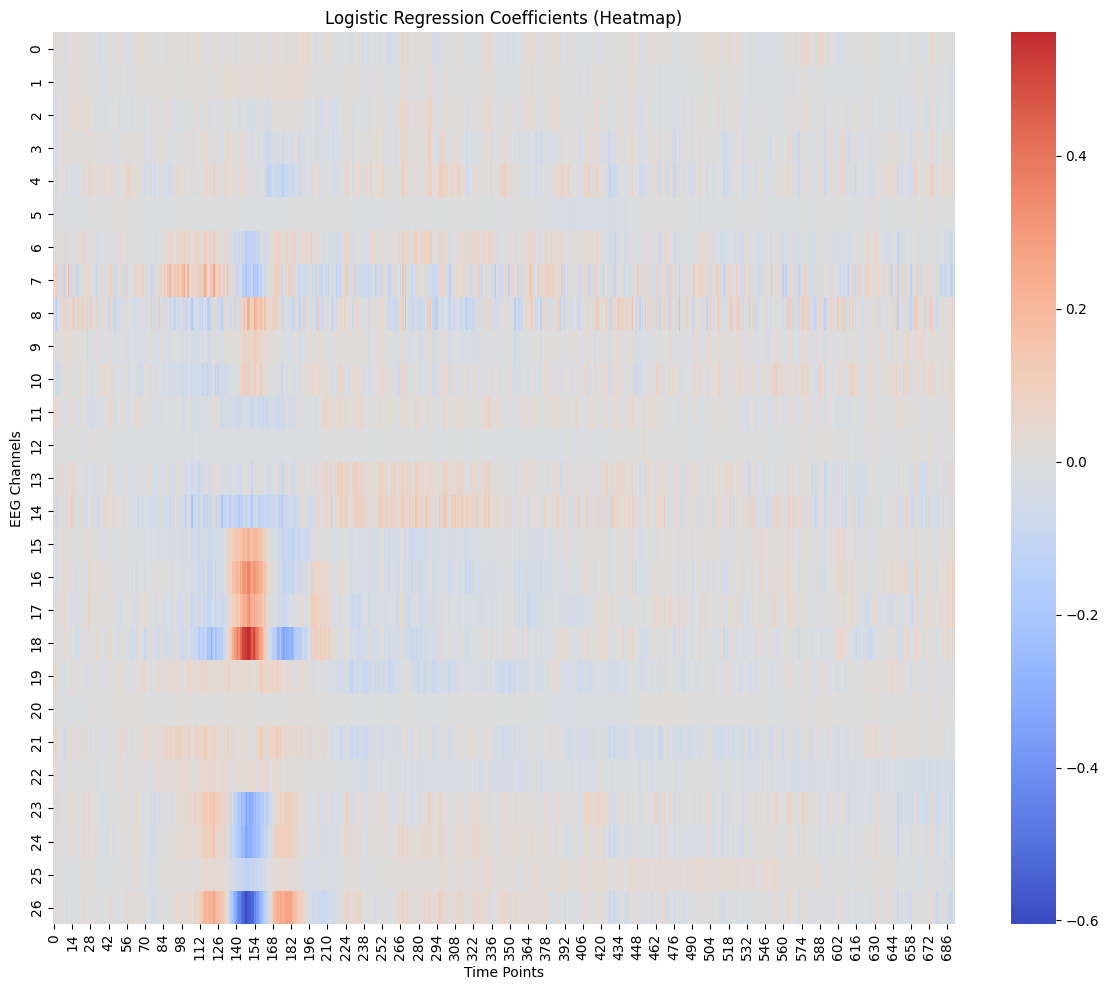

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# reshape the coefficients to the shape of the EEG data for visualization
coefficients_reshaped = coefficients.reshape(692, 27)

# visualize the coefficients using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(coefficients_reshaped.T, cmap='coolwarm', center=0)
plt.title('Logistic Regression Coefficients (Heatmap)')
plt.xlabel('Time Points')
plt.ylabel('EEG Channels')
#plt.colorbar(label='Coefficient Value')
plt.tight_layout()
plt.show()


# Temporal Structure Analysis and Logistic Regression Coefficients

This map allows us to inspect the **temporal structure** captured by the model, which is often **lost when classifying based solely on topological maps**. In the **coefficient significance heatmap**, the most significant positive and negative coefficients are found in the time window from **0.1 to 0.3 seconds**. This period corresponds to when the brain is processing the cue and initiating motor imagery movements. During this window, the signal is most differentiated between the two hands, which allows the model to distinguish the motor imagery task effectively.

However, after **approximately 0.3 seconds**, even though the participant continues to perform motor imagery, the signal differentiation decreases to a level that the logistic regression model can no longer detect reliably.

### Symmetry in Electrode Coefficients

We can also observe **high significance in certain electrodes** that are **symmetric across the scalp** but have **opposite coefficients**. For instance, **P4** shows a strong **positive coefficient** at around **0.2 seconds**, while **P3**—which is its symmetric counterpart—exhibits the strongest **negative coefficient** at the same time. This indicates lateralized brain activity in response to motor imagery, highlighting the importance of these specific electrodes in capturing the relevant signals.

### Motor Imagery Suppression and Opposite Activation Patterns

Around these maximum spots, we notice that **a few milliseconds before and after the strongest coefficients**—from **0.1 to 0.15 seconds** and **0.25 to 0.3 seconds**—the opposite color surrounds the activation. This could represent the **suppression of brain activity before and after the motor imagery activation**. This **suppression effect** is likely an essential part of the motor imagery process and may explain the distinct coefficient patterns observed.

### Proposed Method: Combining Temporal and Spatial Structure

This pattern—where opposite activations surround the peak activations—doesn’t transfer well to topological maps, as it only **dampens the strongest signals**. This could explain why the model achieves **higher accuracies using raw data** rather than topological data. The **temporal structure** that the logistic regression model captures from raw data is lost when using purely topological maps.

To mitigate this, we propose a method that combines both **temporal and spatial structure**: by stacking **2D topological maps** at the **most important time points**, specifically **0.15, 0.2, and 0.25 seconds**, we can retain the temporal information while leveraging the spatial structure provided by the topological maps. Using an average of time points around these moments, we can ensure that the model captures the essential temporal features, without overly increasing computational complexity. This is critical in **BCI (Brain-Computer Interface) applications**, where real-time processing is required, particularly during the calibration period.

### Conclusion: Importance of Timing in Logistic Regression

The logistic regression model shows its most important features in the milliseconds **following the cue onset**, suggesting that the time points immediately after the cue are the most critical for distinguishing motor imagery. Although participants should still perform motor imagery for at least one second, the model focuses more on the early moments of the task. This is likely due to the **brain's immediate response** to the cue, which becomes less distinguishable as the motor imagery continues.


In [ ]:
channel_names=raw.ch_names

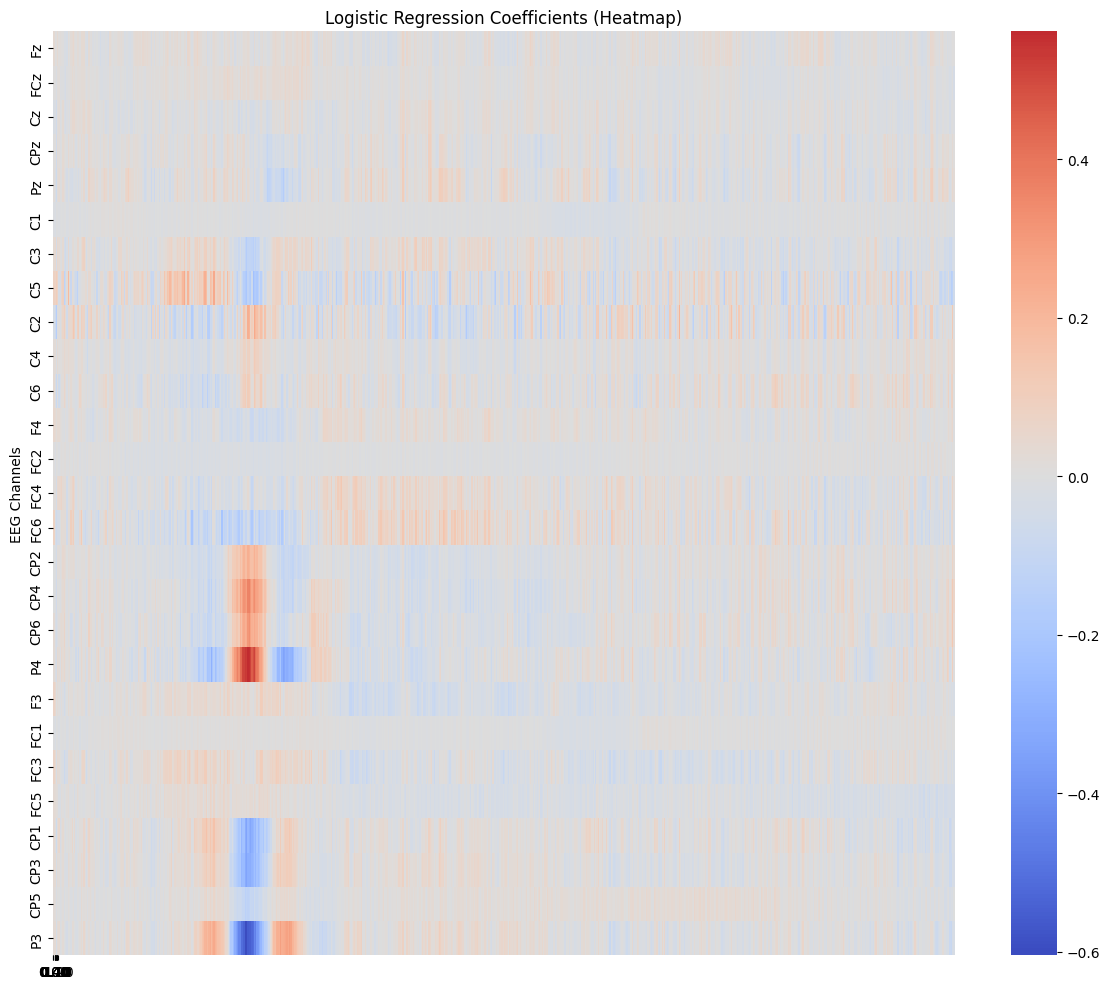

In [22]:
# Generate the desired time points at intervals of 0.1 seconds
desired_time_points = np.arange(tmin, tmax + 0.05, 0.1)




time_points = np.linspace(tmin, tmax + 0.05, 5)#(start_time, end_time, num_points)


# Find the indices of these time points in the original time_points array
indices = [np.argmin(np.abs(time_points - tp)) for tp in desired_time_points]

# Format the desired time points with 2 decimal places for display
formatted_time_points = ["{:.2f}".format(tp) for tp in desired_time_points]

# When plotting your heatmap:
plt.figure(figsize=(12, 10))
sns.heatmap(coefficients_reshaped.T, cmap='coolwarm', center=0,  fmt=".2f", yticklabels=channel_names)
plt.title('Logistic Regression Coefficients (Heatmap)')
plt.xticks(indices, formatted_time_points, rotation=0)  # Set the x-axis labels horizontally and with the specified time points
plt.ylabel('EEG Channels')
plt.tight_layout()
plt.show()


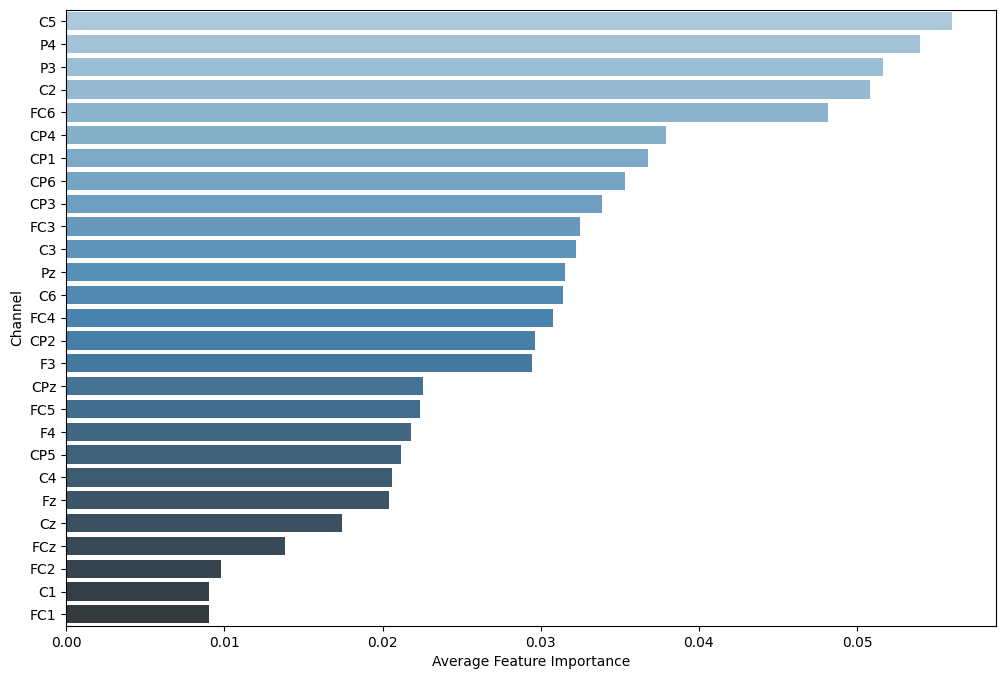

   Channel  Importance
7       C5    0.056010
18      P4    0.053965
26      P3    0.051637
8       C2    0.050811
14     FC6    0.048142
16     CP4    0.037941
23     CP1    0.036787
17     CP6    0.035349
24     CP3    0.033878
21     FC3    0.032492
6       C3    0.032237
4       Pz    0.031567
10      C6    0.031402
13     FC4    0.030798
15     CP2    0.029631
19      F3    0.029428
3      CPz    0.022527
22     FC5    0.022370
11      F4    0.021813
25     CP5    0.021154
9       C4    0.020579
0       Fz    0.020436
2       Cz    0.017427
1      FCz    0.013856
12     FC2    0.009759
5       C1    0.009050
20     FC1    0.009024


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Compute the average feature importance across time points for each channel
avg_importance = np.mean(np.abs(coefficients_reshaped), axis=0)

# Convert the data to a DataFrame for easier plotting and tabulation
df_importance = pd.DataFrame({
    'Channel': channel_names,  # Assuming you've extracted the channels used in your dataset
    'Importance': avg_importance
})

# Sort the channels by importance for a better visualization
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Channel', data=df_importance, palette='Blues_d')
#plt.title('Feature Importance per Channel')
plt.xlabel('Average Feature Importance')
plt.ylabel('Channel')
plt.show()

print(df_importance)


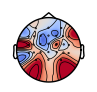

(<matplotlib.image.AxesImage at 0x7870001c8f70>,
 <matplotlib.contour.QuadContourSet at 0x7870001c9480>)

In [ ]:
import numpy as np
import mne

# Compute average feature importance across time points for each channel
avg_importance = np.mean(np.abs(coefficients_reshaped), axis=0)

# Load the montage and info structure to get channel positions
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names=channel_names, sfreq=512, ch_types='eeg')
info.set_montage(montage)

# Plot the topomap
mne.viz.plot_topomap(avg_importance, info, cmap='coolwarm', show=True)


In [ ]:

# Create a time vector based on the number of time points in the ERP data
time_vector = np.linspace(tmin, tmax, erp_left.shape[0])

import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the coefficients to the shape of the EEG data for visualization
coefficients_reshaped = coefficients.reshape(692, 27)

# Create the montage to get the channel names
#montage = mne.channels.make_standard_montage('standard_1020')
#channel_names = montage.ch_names

# Visualize the coefficients using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(coefficients_reshaped.T, cmap='coolwarm', center=0,  fmt=".2f", yticklabels=channel_names) #annot=True,
plt.title('Logistic Regression Coefficients (Heatmap)')
plt.xlabel('Time Points')
plt.ylabel('EEG Channels')
plt.tight_layout()
plt.show()


In [ ]:
channel_names=raw.ch_names

In [ ]:
print(df_importance)


   Channel  Importance
7       C5    0.056010
18      P4    0.053965
26      P3    0.051637
8       C2    0.050811
14     FC6    0.048142
16     CP4    0.037941
23     CP1    0.036787
17     CP6    0.035349
24     CP3    0.033878
21     FC3    0.032492
6       C3    0.032237
4       Pz    0.031567
10      C6    0.031402
13     FC4    0.030798
15     CP2    0.029631
19      F3    0.029428
3      CPz    0.022527
22     FC5    0.022370
11      F4    0.021813
25     CP5    0.021154
9       C4    0.020579
0       Fz    0.020436
2       Cz    0.017427
1      FCz    0.013856
12     FC2    0.009759
5       C1    0.009050
20     FC1    0.009024


In [ ]:
channel_names_array=np.array(channel_names)

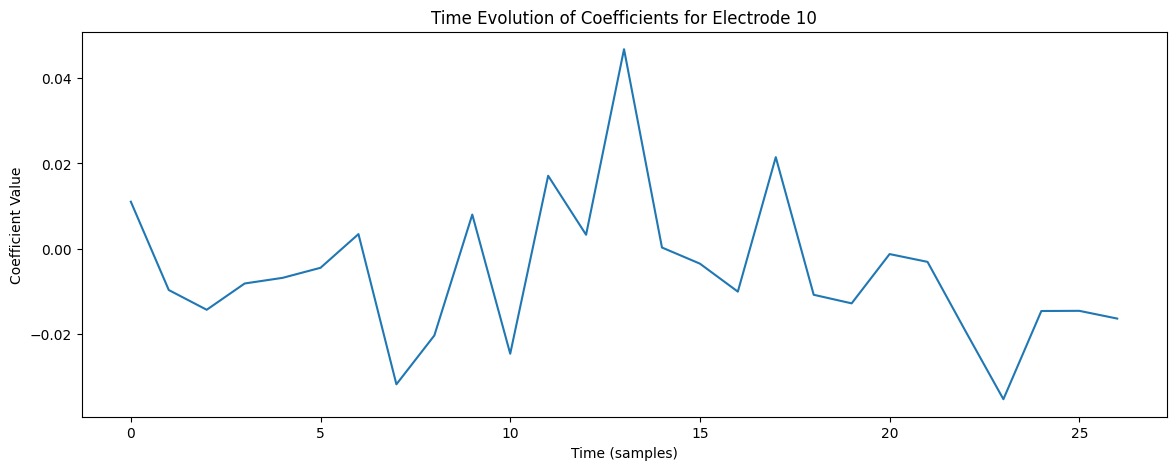

In [ ]:
# Plot the time evolution of coefficients for a specific electrode (e.g., the 10th electrode)
plt.figure(figsize=(14, 5))
plt.plot(coefficients_reshaped[ 5])#:,
plt.xlabel('Time (samples)')
plt.ylabel('Coefficient Value')
plt.title('Time Evolution of Coefficients for Electrode 10')
plt.show()


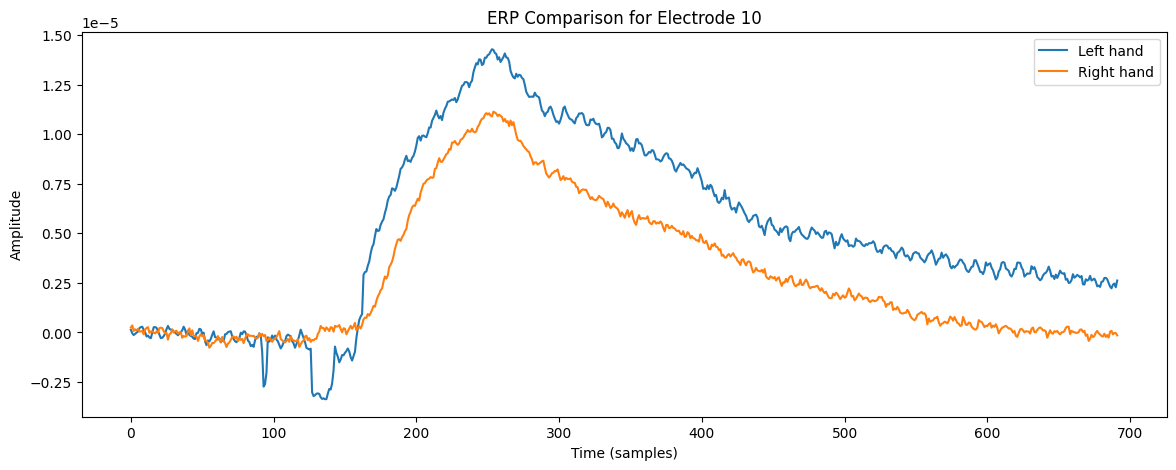

In [ ]:
erp_left = np.mean(X[y == 0], axis=0)
erp_right = np.mean(X[y == 1], axis=0)

# Plot the ERP for a specific electrode (here the 10th electrode)
plt.figure(figsize=(14, 5))
plt.plot(erp_left[:, 9], label='Left hand')
plt.plot(erp_right[:, 9], label='Right hand')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('ERP Comparison for Electrode 10')
plt.show()


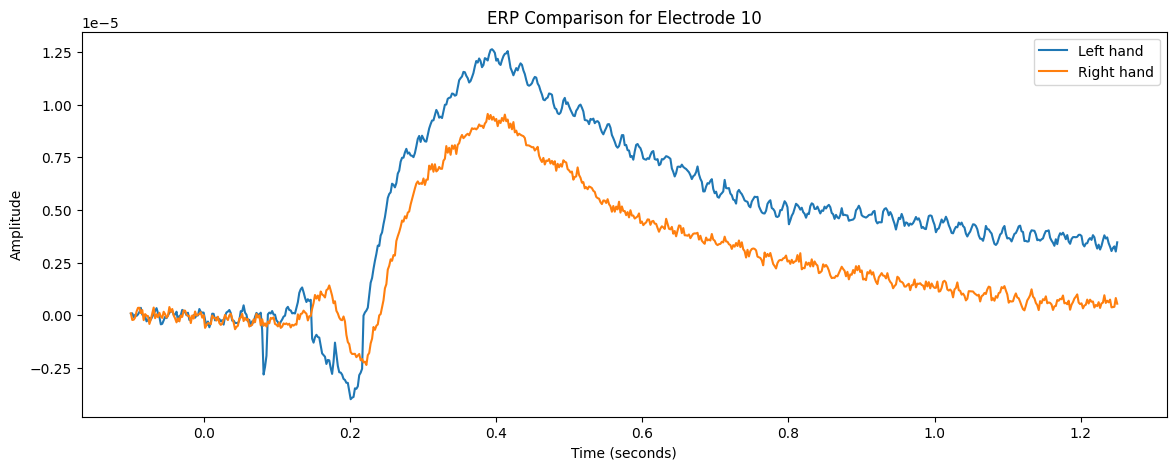

In [ ]:
# Create a time vector based on the number of time points in the ERP data
time_vector = np.linspace(tmin, tmax, erp_left.shape[0])

plt.figure(figsize=(14, 5))
plt.plot(time_vector, erp_left[:, 17], label='Left hand')
plt.plot(time_vector, erp_right[:, 17], label='Right hand')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.title('ERP Comparison for Electrode 10')
plt.show()


In [ ]:
def get_erp_stats(erp_data, time_vector):
    # Peak amplitude and corresponding time
    max_amplitude = np.max(erp_data)
    min_amplitude = np.min(erp_data)
    time_of_max = time_vector[np.argmax(erp_data)]
    time_of_min = time_vector[np.argmin(erp_data)]

    # Mean amplitude
    mean_amplitude = np.mean(erp_data)

    # Standard deviation
    std_deviation = np.std(erp_data)

    return {
        'Max Amplitude': max_amplitude,
        'Time of Max Amplitude': time_of_max,
        'Min Amplitude': min_amplitude,
        'Time of Min Amplitude': time_of_min,
        'Mean Amplitude': mean_amplitude,
        'Standard Deviation': std_deviation
    }

# Get ERP stats for 'Left hand' and 'Right hand'
left_hand_stats = get_erp_stats(erp_left[:, 9], time_vector)
right_hand_stats = get_erp_stats(erp_right[:, 9], time_vector)

# Time of peak difference
difference = np.abs(erp_left[:, 9] - erp_right[:, 9])
time_of_peak_difference = time_vector[np.argmax(difference)]

left_hand_stats, right_hand_stats, time_of_peak_difference


({'Max Amplitude': 1.4294073755188156e-05,
  'Time of Max Amplitude': 0.3942836468885673,
  'Min Amplitude': -3.3736909150293566e-06,
  'Time of Min Amplitude': 0.16570188133140376,
  'Mean Amplitude': 5.103271551473678e-06,
  'Standard Deviation': 4.425536391220885e-06},
 {'Max Amplitude': 1.1142321304330987e-05,
  'Time of Max Amplitude': 0.39623733719247467,
  'Min Amplitude': -7.727696433994647e-07,
  'Time of Min Amplitude': 0.007452966714905931,
  'Mean Amplitude': 2.9617822686205455e-06,
  'Standard Deviation': 3.447783057191486e-06},
 0.5916063675832128)